In [1]:
# Quick example of FastAI implementation for catcus identification using DenseNet 

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


In [2]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch

In [3]:
# assign data folder
data_folder = Path("../input")

In [4]:
# read in training and testing data frames
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/sample_submission.csv")

In [5]:
# create testing image list 
test_img = ImageList.from_df(test_df, path=data_folder/'test', folder='test')

# perform image augmentations to enhance training data
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
train_img = (ImageList.from_df(train_df, path=data_folder/'train', folder='train')
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=128)
        .databunch(path='.', bs=64, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

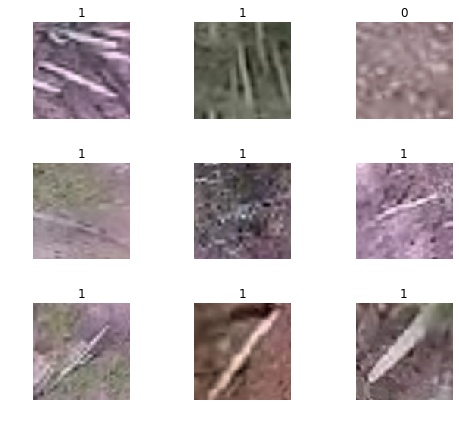

In [6]:
# display training data 
train_img.show_batch(rows=3, figsize=(7,6))

In [7]:
# create CNN model using Fast AI
# this model is based on DensetNet
learn = cnn_learner(train_img, models.densenet161, metrics=[error_rate, accuracy]) 

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth
115730790it [00:04, 26394704.04it/s]


In [8]:
#learn.lr_find()
#learn.recorder.plot()

# set learning parameters
lr = 3e-02 
# train the model
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.041904,0.000312,0.000000,1.000000,01:25
1,0.076379,0.000330,0.000000,1.000000,01:08
2,0.022293,0.022242,0.005714,0.994286,01:10
3,0.009428,0.000071,0.000000,1.000000,01:09
4,0.006905,0.000010,0.000000,1.000000,01:10


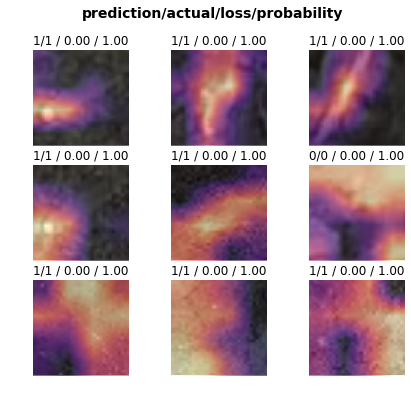

In [9]:
# interperate classification results
interp = ClassificationInterpretation.from_learner(learn)

# plot some images with prediction results
interp.plot_top_losses(9, figsize=(7,6))

In [10]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)
test_df.has_cactus = preds.numpy()[:, 0]

# create submission csv file
test_df.to_csv('submission.csv', index=False)